In [1]:
import pandas as pd
import numpy as np

# 1) Load raw
path = "/Users/erikborn/Documents/Python/jupyter/Salary_ML/cohortData.csv"   # adjust if needed
raw = pd.read_csv(path)

# 2) Clean currency strings -> numeric
def to_num(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    x = str(x).strip().replace("$","").replace(",","")
    try:
        return float(x)
    except ValueError:
        return np.nan

label_col = "Local"
base_col = "Full-Time Teacher Base Salaries: Starting ($)" if "Full-Time Teacher Base Salaries: Starting ($)" in raw.columns else None
band_cols = [c for c in raw.columns if c not in [label_col, base_col] and c is not None]

clean = raw.copy()
if base_col:
    clean[base_col] = clean[base_col].map(to_num)
for c in band_cols:
    clean[c] = clean[c].map(to_num)

# 3) Normalize percentile labels -> numeric values
label_norm = clean[label_col].str.lower().str.strip()
label_norm = label_norm.replace({
    "90th percentile": "p90",
    "75th percentile": "p75",
    "50th percentile (median)": "p50",
    "25th percentile": "p25",
    "10th percentile": "p10",
})
clean["percentile_label"] = label_norm
percentile_map = {"p10":10, "p25":25, "p50":50, "p75":75, "p90":90}
clean["percentile"] = clean["percentile_label"].map(percentile_map)

# 4) Reshape to tidy long format
long = clean.melt(
    id_vars=["percentile_label","percentile"] + ([base_col] if base_col else []),
    value_vars=band_cols,
    var_name="experience_band",
    value_name="salary"
).sort_values(["experience_band","percentile"])

# 5) Helper interpolation function
def interpolate_salary(df_long, experience_band, target_percentile):
    """
    Linear interpolation within one experience_band across the available percentiles.
    target_percentile: e.g., 62.5 meaning the 62.5th percentile.
    Returns a float (salary) or np.nan if insufficient data.
    """
    sub = df_long[df_long["experience_band"] == experience_band].dropna(subset=["percentile","salary"])
    sub = sub.sort_values("percentile")
    if sub.empty or sub["salary"].isna().all():
        return np.nan
    xs = sub["percentile"].to_numpy()
    ys = sub["salary"].to_numpy()
    # Clip to range [min(xs), max(xs)]
    t = np.clip(target_percentile, xs.min(), xs.max())
    return float(np.interp(t, xs, ys))

# Example usage:
example_val = interpolate_salary(long, "0-5 yrs", 62.5)
print(example_val)

61421.5


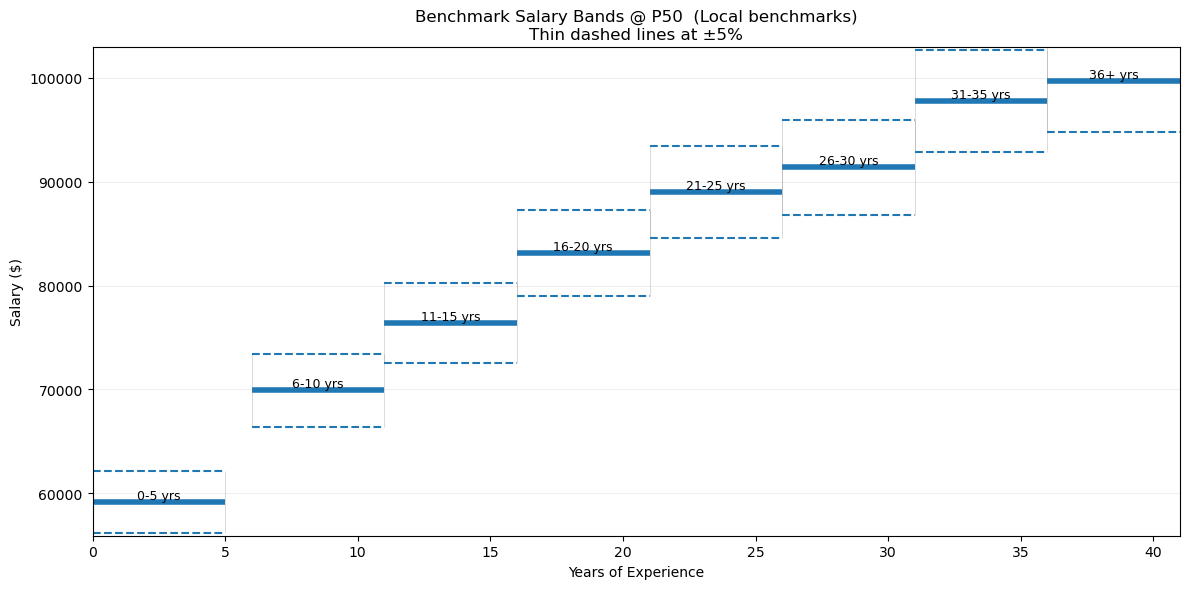

In [2]:
# --- Plot salary bands as horizontal 5-year segments with +/- pct guides ---

import re
import numpy as np
import matplotlib.pyplot as plt

# Inputs you can tune
target_percentile = 50   # e.g., 50 for median, 62.5, 75, etc.
plus_minus_pct    = 5/100.   # 10% bands around the target
title_suffix      = "Local benchmarks"

# Utility: map band label -> (start_year, end_year) with 5-year span
def band_range(label: str):
    """
    Accepts labels like '0-5 yrs', '6-10 yrs', ..., '36+ yrs'.
    Returns (start, end) where end = start + 5.
    """
    m = re.match(r"^\s*(\d+)\s*(?:-\s*\d+|\+)\s*yrs\s*$", str(label))
    if not m:
        raise ValueError(f"Unrecognized band label: {label}")
    start = int(m.group(1))
    end = start + 5
    return start, end

# Get interpolated salary for each band at the chosen percentile
bands = sorted(long["experience_band"].unique(), key=lambda b: band_range(b)[0])

segments = []
for b in bands:
    y = interpolate_salary(long, b, target_percentile)
    if np.isnan(y):
        continue
    x0, x1 = band_range(b)
    segments.append({"band": b, "x0": x0, "x1": x1, "y": y})

if not segments:
    raise RuntimeError("No segments to plot. Check your data and percentile selection.")

# Determine plot bounds
max_x = max(s["x1"] for s in segments)
min_y = min(s["y"] for s in segments)
max_y = max(s["y"] for s in segments)
y_pad = 0.08 * (max_y - min_y if max_y > min_y else max_y)  # padding for y-lims

# Plot
plt.figure(figsize=(12, 6))

for s in segments:
    # Main band line (thick, blue)
    plt.hlines(s["y"], s["x0"], s["x1"], linewidth=4, color="C0")
    # +/- percentage guides (thin, dashed, blue)
    y_lo = s["y"] * (1 - plus_minus_pct)
    y_hi = s["y"] * (1 + plus_minus_pct)
    plt.hlines(y_lo, s["x0"], s["x1"], linewidth=1.5, linestyles="dashed", color="C0")
    plt.hlines(y_hi, s["x0"], s["x1"], linewidth=1.5, linestyles="dashed", color="C0")
    # Optional: faint vertical markers at band edges
    plt.vlines([s["x0"], s["x1"]], ymin=y_lo, ymax=y_hi, colors="gray", linewidth=0.5, alpha=0.4)

# Cosmetics
plt.xlim(0, max_x)
plt.ylim((min_y - y_pad, max_y + y_pad))
plt.xlabel("Years of Experience")
plt.ylabel("Salary ($)")
plt.title(f"Benchmark Salary Bands @ P{target_percentile:g}  ({title_suffix})\n"
          f"Thin dashed lines at ±{plus_minus_pct*100:.0f}%")
plt.grid(axis="y", alpha=0.2)

# X ticks every 5 years to align with bands
xticks = np.arange(0, max_x + 1, 5)
plt.xticks(xticks)

# Optional: annotate band labels at midpoints
for s in segments:
    mid_x = (s["x0"] + s["x1"]) / 2
    plt.text(mid_x, s["y"], s["band"], ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

In [3]:
# # --- Interactive salary-band plot (contiguous bands, fixed y-window, working +/- slider) ---

# import re
# import numpy as np
# import matplotlib.pyplot as plt
# from ipywidgets import interact, IntSlider, FloatSlider
# from functools import lru_cache

# # Assumes you already have:
# #   - `long` (tidy DataFrame)
# #   - `interpolate_salary(long, band, percentile)` from earlier

# # Parse label -> contiguous 5-year span:
# # "0-5 yrs" -> (0,5), "6-10 yrs" -> (5,10), "11-15 yrs" -> (10,15), "36+ yrs" -> (35,40)
# def band_range_contiguous(label: str):
#     m = re.match(r"^\s*(\d+)\s*(?:-\s*(\d+)|\+)\s*yrs\s*$", str(label))
#     if not m:
#         raise ValueError(f"Unrecognized band label: {label}")
#     a = int(m.group(1))
#     has_upper = m.group(2) is not None
#     start = a if a == 0 else a - 1  # shift all non-zero starts back by 1 year
#     end = start + 5
#     return start, end

# # Bands ordered by their contiguous start year
# bands = sorted(long["experience_band"].dropna().unique(),
#                key=lambda b: band_range_contiguous(b)[0])

# # Percentiles we’ll support with the slider
# percentiles = list(range(10, 91, 5))

# # Precompute salaries for each band x percentile
# @lru_cache(maxsize=None)
# def precomputed_for_percentile(p: int):
#     rows = []
#     for b in bands:
#         y = interpolate_salary(long, b, p)
#         if not np.isnan(y):
#             x0, x1 = band_range_contiguous(b)
#             rows.append({"band": b, "x0": x0, "x1": x1, "y": float(y)})
#     return rows

# # Fixed axes: compute once across all p (and add some headroom)
# all_ys = []
# all_x1 = []
# for p in percentiles:
#     segs = precomputed_for_percentile(p)
#     all_ys.extend([s["y"] for s in segs])
#     all_x1.extend([s["x1"] for s in segs])

# _global_min_y = min(all_ys)
# _global_max_y = max(all_ys)
# _max_x = max(all_x1) if all_x1 else 40

# # Add headroom so dashed lines at larger +/- remain visible without resizing
# _headroom = 0.25  # 25% guard band
# _ymin_fixed = _global_min_y * (1 - _headroom)
# _ymax_fixed = _global_max_y * (1 + _headroom)

# def plot_bands(p=50, plus_minus_pct=0.10, title_suffix="Local benchmarks"):
#     segs = precomputed_for_percentile(int(p))
#     if not segs:
#         raise RuntimeError("No segments to plot. Check data/interpolation.")

#     plt.figure(figsize=(12, 6))

#     for s in segs:
#         # main segment
#         plt.hlines(s["y"], s["x0"], s["x1"], linewidth=4, color="C0")
#         # +/- guides
#         y_lo = s["y"] * (1 - plus_minus_pct)
#         y_hi = s["y"] * (1 + plus_minus_pct)
#         plt.hlines(y_lo, s["x0"], s["x1"], linewidth=1.5, linestyles="dashed", color="C0")
#         plt.hlines(y_hi, s["x0"], s["x1"], linewidth=1.5, linestyles="dashed", color="C0")
#         # optional verticals
#         plt.vlines([s["x0"], s["x1"]], ymin=y_lo, ymax=y_hi, colors="gray", linewidth=0.5, alpha=0.4)

#         # label
#         mid_x = (s["x0"] + s["x1"]) / 2
#         plt.text(mid_x, s["y"], s["band"], ha="center", va="bottom", fontsize=9)

#     # fixed axes (do not resize as slider moves)
#     plt.xlim(0, _max_x)
#     plt.ylim(_ymin_fixed, _ymax_fixed)

#     plt.xlabel("Years of Experience")
#     plt.ylabel("Salary ($)")
#     plt.title(f"Benchmark Salary Bands @ P{int(p)}  ({title_suffix})\n"
#               f"Thin dashed lines at ±{plus_minus_pct*100:.0f}%")
#     plt.grid(axis="y", alpha=0.2)
#     plt.xticks(np.arange(0, _max_x + 1, 5))
#     plt.tight_layout()
#     plt.show()

# # Interactive controls
# interact(
#     plot_bands,
#     p=IntSlider(value=50, min=10, max=90, step=5, description="Percentile"),
#     plus_minus_pct=FloatSlider(value=0.10, min=0.00, max=0.30, step=0.01,
#                                readout_format=".2f", description="± Fraction"),
# );

       Years of Exp  25-26 Salary
count         78.00         78.00
mean          14.35      70832.19
std            9.99      10685.39
min            0.00      52125.00
25%            7.00      65223.00
50%           13.00      69848.00
75%           18.75      76892.50
max           48.00     101894.00


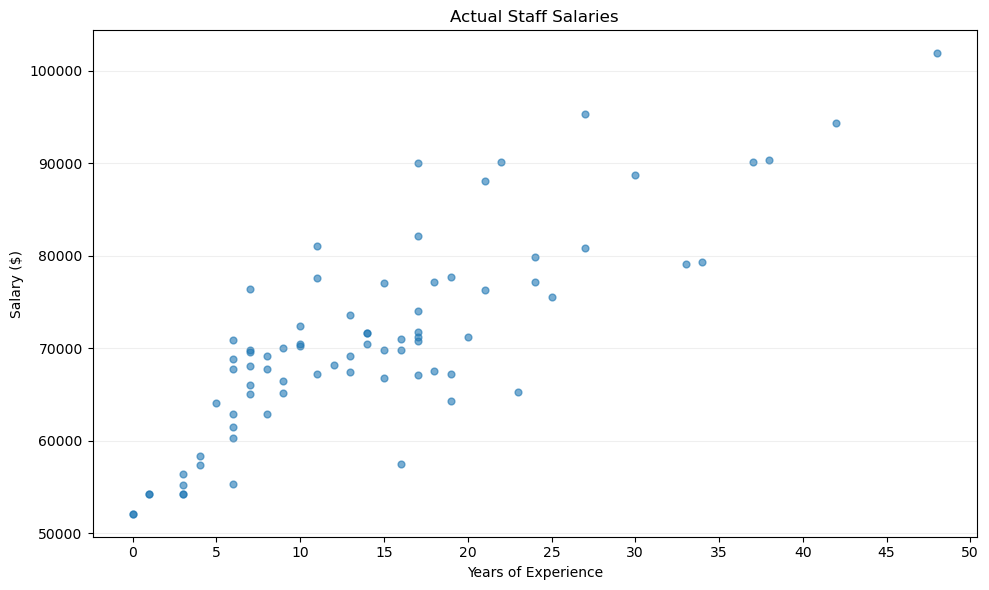

In [4]:
# --- Load & clean staff salary CSV, then plot salaries vs. years of experience ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====== CONFIG ======
path_staff = "/Users/erikborn/Documents/Python/jupyter/Salary_ML/modelData3.csv"  # <-- set your file name/path
salary_col = "25-26 Salary"
years_col  = "Years of Exp"        # expects numeric (int/float)
# ====================

# Helpers
def to_num_currency(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).strip().replace("$", "").replace(",", "")
    try:
        return float(s)
    except ValueError:
        return np.nan

def coerce_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

# Load
staff_raw = pd.read_csv(path_staff)

# Basic standardization of columns (optional, in case incoming headers have stray whitespace)
staff_raw.columns = [c.strip() for c in staff_raw.columns]

expected_cols = {
    "Employee","ID","25-26 Salary","Hire Date","Gender","Years of Exp","Seniority",
    "Education Level","Skill Rating","Knowledge Rating","Prep Rating","Level"
}
missing = [c for c in expected_cols if c not in staff_raw.columns]
if missing:
    print("Warning: Missing expected columns:", missing)

# Clean numeric fields
staff = staff_raw.copy()
if salary_col in staff.columns:
    staff[salary_col] = staff[salary_col].map(to_num_currency)

if years_col in staff.columns:
    staff[years_col] = staff[years_col].map(coerce_float)

# Drop rows without a salary or years of experience
staff = staff.dropna(subset=[salary_col, years_col])

# Optional: clip out obvious outliers (comment out if you don't want this)
# staff = staff[(staff[years_col] >= 0) & (staff[years_col] <= 45) & (staff[salary_col] > 0)]

# print(f"Rows after cleaning: {len(staff):,}")

# Quick summary
print(staff[[years_col, salary_col]].describe().round(2))

# Scatter plot of actual salaries vs. years of experience
plt.figure(figsize=(10, 6))
plt.scatter(staff[years_col], staff[salary_col], alpha=0.6, s=24)
plt.xlabel("Years of Experience")
plt.ylabel("Salary ($)")
plt.title("Actual Staff Salaries")
plt.grid(axis="y", alpha=0.2)

# Optional: nicer x tick spacing
max_years = (np.nanmax(staff[years_col].to_numpy()) if len(staff) else 40)
plt.xticks(np.arange(0, max(40, int(np.ceil(max_years/5)*5)) + 1, 5))

plt.tight_layout()
# plt.show()

In [5]:
# --- Interactive benchmark bands + actual salaries (red dots) ---

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider
from functools import lru_cache

# ------------------------------------------------------------------
# Assumes you already have:
#   - `long`  (tidy benchmarks from earlier cell)
#   - `interpolate_salary(long, band, percentile)` defined
# And you either already created `staff` (with "Years of Exp", "25-26 Salary"),
# or set `path_staff` below to load it here.
# ------------------------------------------------------------------

# Optional load if not already in memory
def _to_num_currency(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float)): return float(x)
    return float(str(x).replace("$","").replace(",",""))

try:
    staff  # noqa
except NameError:
    path_staff = "staff_salaries.csv"   # <-- change if needed
    staff_raw = pd.read_csv(path_staff)
    staff_raw.columns = [c.strip() for c in staff_raw.columns]
    staff = staff_raw.copy()
    staff["25-26 Salary"] = staff["25-26 Salary"].map(_to_num_currency)
    staff["Years of Exp"] = pd.to_numeric(staff["Years of Exp"], errors="coerce")
    staff = staff.dropna(subset=["25-26 Salary", "Years of Exp"])

# ----- Helpers for contiguous 5-year band spans -----
def band_range_contiguous(label: str):
    # "0-5 yrs" -> (0,5), "6-10 yrs" -> (5,10), "11-15 yrs" -> (10,15), "36+ yrs" -> (35,40)
    m = re.match(r"^\s*(\d+)\s*(?:-\s*(\d+)|\+)\s*yrs\s*$", str(label))
    if not m:
        raise ValueError(f"Unrecognized band label: {label}")
    a = int(m.group(1))
    start = a if a == 0 else a - 1
    end = start + 5
    return start, end

bands = sorted(long["experience_band"].dropna().unique(),
               key=lambda b: band_range_contiguous(b)[0])

percentiles = list(range(10, 91, 5))

@lru_cache(maxsize=None)
def precomputed_for_percentile(p: int):
    rows = []
    for b in bands:
        y = interpolate_salary(long, b, p)
        if not np.isnan(y):
            x0, x1 = band_range_contiguous(b)
            rows.append({"band": b, "x0": x0, "x1": x1, "y": float(y)})
    return rows

# ---- Fixed axes computed once across all percentiles and staff data ----
all_ys = []
all_x1 = []
for p in percentiles:
    segs = precomputed_for_percentile(p)
    all_ys.extend([s["y"] for s in segs])
    all_x1.extend([s["x1"] for s in segs])

# include staff salaries in bounds
if len(staff):
    all_ys.extend(staff["25-26 Salary"].dropna().to_numpy())
    max_years_staff = np.nanmax(staff["Years of Exp"].to_numpy())
else:
    max_years_staff = 0

_global_min_y = float(np.nanmin(all_ys))
_global_max_y = float(np.nanmax(all_ys))
_max_x = max(all_x1 + [max_years_staff, 40])  # at least 40 on x

_headroom = 0.25
_ymin_fixed = _global_min_y * (1 - _headroom)
_ymax_fixed = _global_max_y * (1 + _headroom)

def plot_bands_with_staff(p=50, plus_minus_pct=0.10, title_suffix="Local benchmarks"):
    segs = precomputed_for_percentile(int(p))
    if not segs:
        raise RuntimeError("No segments to plot.")

    plt.figure(figsize=(12, 6))

    # benchmark bands
    for s in segs:
        plt.hlines(s["y"], s["x0"], s["x1"], linewidth=4, color="C0")
        y_lo = s["y"] * (1 - plus_minus_pct)
        y_hi = s["y"] * (1 + plus_minus_pct)
        plt.hlines(y_lo, s["x0"], s["x1"], linewidth=1.5, linestyles="dashed", color="C0")
        plt.hlines(y_hi, s["x0"], s["x1"], linewidth=1.5, linestyles="dashed", color="C0")
        plt.vlines([s["x0"], s["x1"]], ymin=y_lo, ymax=y_hi, colors="gray", linewidth=0.5, alpha=0.35)
        mid_x = (s["x0"] + s["x1"]) / 2
        plt.text(mid_x, s["y"], s["band"], ha="center", va="bottom", fontsize=9)

    # staff points (red dots)
    if len(staff):
        plt.scatter(staff["Years of Exp"], staff["25-26 Salary"], s=20, alpha=0.8, color="C3")

    # fixed axes
    plt.xlim(0, _max_x)
    plt.ylim(_ymin_fixed, _ymax_fixed)

    plt.xlabel("Years of Experience")
    plt.ylabel("Salary ($)")
    plt.title(f"Benchmark Bands @ P{int(p)}  +  Actual Salaries  ({title_suffix})\n"
              f"Dashed lines at ±{plus_minus_pct*100:.0f}%")
    plt.grid(axis="y", alpha=0.2)
    plt.xticks(np.arange(0, _max_x + 1, 5))
    plt.tight_layout()
    plt.show()

# Interactive controls
interact(
    plot_bands_with_staff,
    p=IntSlider(value=50, min=10, max=90, step=5, description="Percentile"),
    plus_minus_pct=FloatSlider(value=0.10, min=0.00, max=0.30, step=0.01,
                               readout_format=".2f", description="± Fraction"),
);

interactive(children=(IntSlider(value=50, description='Percentile', max=90, min=10, step=5), FloatSlider(value…

In [6]:
# --- Interactive benchmark bands + staff hover tooltips via mplcursors ---
%pip install -q ipympl mplcursors
%matplotlib widget

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider
from functools import lru_cache

# 1) Install once per kernel if needed:
# %pip install mplcursors
import mplcursors

# Assumes `long`, `interpolate_salary`, and `staff` are already defined as before.

def band_range_contiguous(label: str):
    m = re.match(r"^\s*(\d+)\s*(?:-\s*(\d+)|\+)\s*yrs\s*$", str(label))
    if not m:
        raise ValueError(f"Unrecognized band label: {label}")
    a = int(m.group(1))
    start = a if a == 0 else a - 1
    end = start + 5
    return start, end

bands = sorted(long["experience_band"].dropna().unique(),
               key=lambda b: band_range_contiguous(b)[0])

percentiles = list(range(10, 91, 5))

@lru_cache(maxsize=None)
def precomputed_for_percentile(p: int):
    rows = []
    for b in bands:
        y = interpolate_salary(long, b, p)
        if not np.isnan(y):
            x0, x1 = band_range_contiguous(b)
            rows.append({"band": b, "x0": x0, "x1": x1, "y": float(y)})
    return rows

# Fixed axes (same idea as before)
all_ys, all_x1 = [], []
for p in percentiles:
    segs = precomputed_for_percentile(p)
    all_ys.extend([s["y"] for s in segs])
    all_x1.extend([s["x1"] for s in segs])

if len(staff):
    all_ys.extend(staff["25-26 Salary"].dropna().to_numpy())
    max_years_staff = np.nanmax(staff["Years of Exp"].to_numpy())
else:
    max_years_staff = 0

_global_min_y = float(np.nanmin(all_ys))
_global_max_y = float(np.nanmax(all_ys))
_max_x = max(all_x1 + [max_years_staff, 40])

_headroom = 0.25
_ymin_fixed = _global_min_y * (1 - _headroom)
_ymax_fixed = _global_max_y * (1 + _headroom)

# Prepare a view of staff in the exact order we will plot,
# so indices line up with tooltip lookups.
staff_plot = (
    staff[["Employee", "ID", "Years of Exp", "25-26 Salary", "Level",
           "Education Level", "Gender"]]
    .dropna(subset=["Years of Exp", "25-26 Salary"])
    .copy()
)

def fmt_currency(v: float) -> str:
    return f"${v:,.0f}"

def plot_bands_with_staff_hover(p=50, plus_minus_pct=0.10, title_suffix="Local benchmarks"):
    segs = precomputed_for_percentile(int(p))
    if not segs:
        raise RuntimeError("No segments to plot.")

    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()

    # benchmark bands
    for s in segs:
        ax.hlines(s["y"], s["x0"], s["x1"], linewidth=4)
        y_lo = s["y"] * (1 - plus_minus_pct)
        y_hi = s["y"] * (1 + plus_minus_pct)
        ax.hlines(y_lo, s["x0"], s["x1"], linewidth=1.5, linestyles="dashed")
        ax.hlines(y_hi, s["x0"], s["x1"], linewidth=1.5, linestyles="dashed")
        ax.vlines([s["x0"], s["x1"]], ymin=y_lo, ymax=y_hi, linewidth=0.5, alpha=0.35)
        mid_x = (s["x0"] + s["x1"]) / 2
        ax.text(mid_x, s["y"], s["band"], ha="center", va="bottom", fontsize=9)

    # staff scatter (keep handle for cursor)
    sc = ax.scatter(staff_plot["Years of Exp"], staff_plot["25-26 Salary"], s=22, alpha=0.9, color="red")

    # fixed axes
    ax.set_xlim(0, _max_x)
    ax.set_ylim(_ymin_fixed, _ymax_fixed)
    ax.set_xlabel("Years of Experience")
    ax.set_ylabel("Salary ($)")
    ax.set_title(
        f"Benchmark Bands @ P{int(p)}  +  Actual Salaries  ({title_suffix})\n"
        f"Dashed lines at ±{plus_minus_pct*100:.0f}%"
    )
    ax.grid(axis="y", alpha=0.2)
    ax.set_xticks(np.arange(0, _max_x + 1, 5))
    plt.tight_layout()

    # --- Hover tooltips with mplcursors ---
    cursor = mplcursors.cursor(sc, hover=True)

    @cursor.connect("add")
    def on_add(sel):
        i = sel.index  # index into the PathCollection corresponds to staff_plot row
        row = staff_plot.iloc[i]
        text = (
            f"{row.get('Employee', 'Employee')}\n"
            f"ID: {row.get('ID', '')}\n"
            f"Years: {row['Years of Exp']:.1f}\n"
            f"Salary: {fmt_currency(row['25-26 Salary'])}\n"
            f"Level: {row.get('Level', '')}\n"
            f"Edu: {row.get('Education Level', '')}\n"
            f"Gender: {row.get('Gender', '')}"
        )
        sel.annotation.set_text(text)
        sel.annotation.get_bbox_patch().set_alpha(0.9)

    plt.show()

# Widgets (same controls as before)
interact(
    plot_bands_with_staff_hover,
    p=IntSlider(value=50, min=10, max=90, step=5, description="Percentile"),
    plus_minus_pct=FloatSlider(value=0.10, min=0.00, max=0.30, step=0.01,
                               readout_format=".2f", description="± Fraction"),
);

Note: you may need to restart the kernel to use updated packages.


interactive(children=(IntSlider(value=50, description='Percentile', max=90, min=10, step=5), FloatSlider(value…

In [7]:
# --- Cost model: bring each band to a chosen percentile (default: median/P50) ---

import re
import numpy as np
import pandas as pd

# Assumes you already have:
#   - `long` tidy benchmarks (experience_band, percentile, salary, ...)
#   - `interpolate_salary(long, band, target_percentile)` defined
#   - `staff` DataFrame with columns "Years of Exp" and "25-26 Salary" at minimum

# 1) Contiguous 5-year spans from benchmark labels
#    "0-5 yrs" -> [0,5), "6-10 yrs" -> [5,10), "11-15 yrs" -> [10,15), "36+ yrs" -> [35, inf)
def band_range_contiguous(label: str):
    m = re.match(r"^\s*(\d+)\s*(?:-\s*(\d+)|\+)\s*yrs\s*$", str(label))
    if not m:
        raise ValueError(f"Unrecognized band label: {label}")
    a = int(m.group(1))
    start = a if a == 0 else a - 1
    # If it's a "+" band, treat as open-ended above start+5 (we'll handle explicitly)
    end = start + 5
    return start, end

def build_band_bins(long_df: pd.DataFrame):
    bands = sorted(long_df["experience_band"].dropna().unique(),
                   key=lambda b: band_range_contiguous(b)[0])
    bins = []
    for b in bands:
        s, e = band_range_contiguous(b)
        # detect the last "+ yrs" band
        if "+" in str(b):
            bins.append((s, np.inf, b))
        else:
            bins.append((s, e, b))
    return bins

def assign_band_from_years(years: float, bins):
    if pd.isna(years):
        return np.nan
    for s, e, label in bins:
        if e == np.inf:
            if years >= s:
                return label
        else:
            if (years >= s) and (years < e):
                return label
    return np.nan  # outside defined bins

# 2) Compute cost table for a chosen percentile
def cost_to_percentile(long_df: pd.DataFrame,
                       staff_df: pd.DataFrame,
                       target_percentile: float = 50.0,
                       salary_col: str = "25-26 Salary",
                       years_col: str = "Years of Exp",
                       round_to: int = 1,
                       target_inflation: float = 0.0):
    """
    Estimate cost to bring all staff in each band to the chosen percentile.

    target_inflation: forward-looking inflation factor applied to the target salaries.
                      e.g., 0.03 means +3% to all benchmark targets.
    """
    bins = build_band_bins(long_df)

    staff_view = staff_df[[years_col, salary_col]].copy()
    staff_view["band"] = staff_view[years_col].apply(lambda y: assign_band_from_years(y, bins))

    # Compute target salary per band (*** inflation applied here ***)
    band_targets = []
    for _, _, b in bins:
        y = interpolate_salary(long_df, b, target_percentile)
        if not np.isnan(y):
            inflated = float(y) * (1 + target_inflation)
            band_targets.append((b, inflated))
    target_map = dict(band_targets)

    # Aggregate current totals per band
    per_band = (
        staff_view
        .dropna(subset=["band", salary_col])
        .groupby("band", as_index=False)
        .agg(headcount=(salary_col, "size"),
             current_total=(salary_col, "sum"))
    )

    per_band["target_salary"] = per_band["band"].map(target_map)
    per_band["target_total"] = per_band["headcount"] * per_band["target_salary"]
    per_band["delta"] = per_band["target_total"] - per_band["current_total"]
    per_band["delta_per_head"] = per_band["delta"] / per_band["headcount"].replace({0: np.nan})

    per_band["__start__"] = per_band["band"].apply(lambda b: band_range_contiguous(b)[0] if pd.notna(b) else 1e9)
    per_band = per_band.sort_values("__start__").drop(columns="__start__")

    # Rounding
    money_cols = ["current_total", "target_salary", "target_total", "delta", "delta_per_head"]
    for c in money_cols:
        if c in per_band.columns:
            per_band[c] = per_band[c].round(0 if round_to == 1 else -int(np.log10(round_to)))

    # Totals
    totals = {
        "band": "TOTAL",
        "headcount": int(per_band["headcount"].sum()) if "headcount" in per_band else 0,
        "current_total": per_band["current_total"].sum(),
        "target_salary": np.nan,
        "target_total": per_band["target_total"].sum(),
        "delta": per_band["delta"].sum(),
        "delta_per_head": per_band["delta"].sum() / max(per_band["headcount"].sum(), 1),
    }
    totals = {k: (round(v) if isinstance(v, (int, float, np.floating)) and not pd.isna(v) else v) for k, v in totals.items()}

    return pd.concat([per_band, pd.DataFrame([totals])], ignore_index=True)

# 3) Example usage (P50 median). Change target_percentile to try others (e.g., 60, 75).
result = cost_to_percentile(long, staff, target_percentile=50, target_inflation=0.04, salary_col="25-26 Salary", years_col="Years of Exp")
result

def fmt_money(x):
    return "" if pd.isna(x) else f"${x:,.0f}"

display(
    result.style.format({
        "current_total": fmt_money,
        "target_salary": fmt_money,
        "target_total": fmt_money,
        "delta": fmt_money,
        "delta_per_head": fmt_money
    })
)

,band,headcount,current_total,target_salary,target_total,delta,delta_per_head
0,0-5 yrs,10,"$548,716","$61,530","$615,295","$66,579","$6,658"
1,6-10 yrs,20,"$1,328,221","$72,696","$1,453,920","$125,699","$6,285"
2,11-15 yrs,13,"$931,155","$79,456","$1,032,928","$101,773","$7,829"
3,16-20 yrs,18,"$1,292,977","$86,476","$1,556,568","$263,591","$14,644"
4,21-25 yrs,7,"$548,067","$92,560","$647,920","$99,853","$14,265"
5,26-30 yrs,3,"$251,760","$95,035","$285,106","$33,346","$11,115"
6,31-35 yrs,3,"$247,268","$101,666","$304,999","$57,731","$19,244"
7,36+ yrs,4,"$376,747","$103,719","$414,877","$38,130","$9,532"
8,TOTAL,78,"$5,524,911",,"$6,311,613","$786,702","$10,086"


In [8]:
# --- Perfect-World Salary Model (tweaked for this notebook & your staff schema) ---

import pandas as pd
import numpy as np
import re

# Assumes you already have `staff` loaded with columns including:
# "Years of Exp", "Seniority", "Skill Rating", "Prep Rating", "Knowledge Rating",
# "Education Level", "Level", "Gender"
#
# This cell:
# 1) builds X (feature matrix) from `staff` with one-hots that match your coeff keys,
# 2) defines your coefficient dict,
# 3) predicts "Perfect World Salary" into `staff["Perfect World Salary"]`.

# -----------------------------
# Helpers: make experience bands aligned to your coefficient names
# -----------------------------
def contiguous_band(years: float):
    """Return your label set: 00-05, 06-10, 11-15, 16-20, 21-25, 26-30, 30+."""
    if pd.isna(years):
        return np.nan
    y = float(years)
    if y < 5:   return "00-05"
    if y < 10:  return "06-10"
    if y < 15:  return "11-15"
    if y < 20:  return "16-20"
    if y < 25:  return "21-25"
    if y < 30:  return "26-30"
    return "30+"

# -----------------------------
# Build feature matrix X from `staff`
# -----------------------------
sf = staff.copy()

# Normalize categorical fields we will one-hot
sf["Education Level"] = sf.get("Education Level", pd.Series(index=sf.index, dtype="object")).astype(str).str.strip().str.upper()
sf["Level"]           = sf.get("Level",           pd.Series(index=sf.index, dtype="object")).astype(str).str.strip().str.upper()
sf["Gender"]          = sf.get("Gender",          pd.Series(index=sf.index, dtype="object")).astype(str).str.strip().str.upper()

# Experience band categorical
sf["Experience Band"] = sf["Years of Exp"].apply(contiguous_band)

# One-hots that match your coefficient keys
edu_d = pd.get_dummies(sf["Education Level"], prefix="Education Level")
lvl_d = pd.get_dummies(sf["Level"],           prefix="Level")
gen_d = pd.get_dummies(sf["Gender"],          prefix="Gender")
exp_d = pd.get_dummies(sf["Experience Band"], prefix="Experience Band")

# Ensure the dummy columns exist even if category absent in current data
for col in ["Education Level_MA", "Education Level_PhD",
            "Level_LS", "Level_MS", "Level_HS",
            "Gender_M",
            "Experience Band_00-05", "Experience Band_06-10", "Experience Band_11-15",
            "Experience Band_16-20", "Experience Band_21-25", "Experience Band_26-30",
            "Experience Band_30+"]:
    if col not in edu_d.columns and col.startswith("Education Level_"):
        edu_d[col] = 0
    if col not in lvl_d.columns and col.startswith("Level_"):
        lvl_d[col] = 0
    if col not in gen_d.columns and col.startswith("Gender_"):
        gen_d[col] = 0
    if col not in exp_d.columns and col.startswith("Experience Band_"):
        exp_d[col] = 0

# Numeric features (coerce missing to 0)
num_cols = ["Years of Exp", "Seniority", "Skill Rating", "Prep Rating", "Knowledge Rating"]
for c in num_cols:
    if c not in sf.columns:
        sf[c] = 0.0
sf[num_cols] = sf[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)

# Assemble X
X = pd.concat(
    [
        sf[num_cols],
        edu_d[["Education Level_MA", "Education Level_PhD"]],
        lvl_d[["Level_LS", "Level_MS", "Level_HS"]],
        gen_d[["Gender_M"]],
        exp_d[[
            "Experience Band_00-05", "Experience Band_06-10", "Experience Band_11-15",
            "Experience Band_16-20", "Experience Band_21-25", "Experience Band_26-30",
            "Experience Band_30+",
        ]],
    ],
    axis=1
).copy()

# -----------------------------
# Step 1: Define your "Perfect World" coefficients
# -----------------------------
step = 2000  # optional staircase increment per higher experience band (kept for continuity)
perfect_world_coeffs = {
    "Years of Exp": 700,
    "Seniority": 300,
    "Skill Rating": 0,
    "Prep Rating": 2500,
    "Knowledge Rating": 1500,
    "Education Level_MA": 1500,
    "Education Level_PhD": 2500,
    "Level_LS": 0,
    "Level_MS": 0,
    "Level_HS": 0,
    "Gender_M": 0,
    # Experience bands (only include if you want them)
    "Experience Band_00-05": 0,
    "Experience Band_06-10": step,
    "Experience Band_11-15": step*4,
    "Experience Band_16-20": step*7,
    "Experience Band_21-25": step*9,
    "Experience Band_26-30": step*10,
    "Experience Band_30+": step*11,
}

# -----------------------------
# Step 2: Predictor using your coefficients
# -----------------------------
def predict_perfect_world_salary(df_X: pd.DataFrame,
                                 coeffs: dict,
                                 base: float = 52000,
                                 aim_multiplier: float = 1.0):
    """
    df_X: feature matrix with columns matching coefficient keys (missing cols assumed 0)
    coeffs: dict of feature -> weight
    base: baseline salary added to everyone
    aim_multiplier: optional global scaling (e.g., to 'aim' the curve to a percentile)
    """
    # Ensure all coefficient keys exist in df_X; create missing as zeros
    for k in coeffs.keys():
        if k not in df_X.columns:
            df_X[k] = 0.0

    # Align to a consistent column order
    cols = list(coeffs.keys())
    weights = np.array([coeffs[k] for k in cols], dtype=float)
    contrib = df_X[cols].to_numpy() @ weights
    return aim_multiplier * (base + contrib)

# -----------------------------
# Step 3: Apply to your dataset
# -----------------------------
# Example: no scaling (aim_multiplier=1.0). Adjust if you later align to an external percentile.
staff["Perfect World Salary"] = predict_perfect_world_salary(X.copy(), perfect_world_coeffs, base=52000, aim_multiplier=1.0)

# Optional: quick check
print("Perfect World Salary created. Preview:")
staff[["Employee", "Years of Exp", "Seniority", "Education Level", "Level", "Perfect World Salary"]].head(10)

Perfect World Salary created. Preview:


,Employee,Years of Exp,Seniority,Education Level,Level,Perfect World Salary
0,"Joella, Katie",0.0,0,BA,HS,52450.0
1,"Elston, Caron L",0.0,2,NaN,LS,53050.0
2,"Dimond, Olivia D",1.0,0,BA,MS,53150.0
3,"Pugh, Hannah E",1.0,0,BA,HS,55650.0
4,"Baumgartner, Rachel C",3.0,1,MA,MS,56350.0
5,Weintraub,3.0,3,NaN,LS,55450.0
6,"Herndon, Natalie R",3.0,0,BA,MS,54850.0
7,"Rosiere, Diana M",3.0,1,MA,MS,56800.0
8,"Porter, Laine M",4.0,0,BA,LS,55250.0
9,"Wang, Zhuoqun",4.0,1,MA,Cross,57650.0


In [9]:
# --- Add Rough Percentile/Band (RPB) salary per person ---

import numpy as np
import pandas as pd
import re

# CONFIG — tune these as you like
target_percentile = 50.0    # e.g., 50 for median, 60, 75, etc.
target_inflation  = 0.00    # e.g., 0.03 for +3% forward look

# Assumes you already have:
#   - `long` (tidy benchmarks with columns: experience_band, percentile, salary)
#   - `interpolate_salary(long, band, target_percentile)` defined
#   - `staff` DataFrame with columns: "Years of Exp", "25-26 Salary" (and others)

# --- Helpers for contiguous bands and mapping years -> band labels used in `long` ---

def band_range_contiguous(label: str):
    """
    Map labels like:
      '0-5 yrs'  -> span [0,5)
      '6-10 yrs' -> span [5,10)
      ...
      '36+ yrs'  -> span [35, inf)
    """
    m = re.match(r"^\s*(\d+)\s*(?:-\s*(\d+)|\+)\s*yrs\s*$", str(label))
    if not m:
        raise ValueError(f"Unrecognized band label: {label}")
    a = int(m.group(1))
    start = a if a == 0 else a - 1
    end = start + 5
    return start, end

def build_band_bins(long_df: pd.DataFrame):
    bands = sorted(
        long_df["experience_band"].dropna().unique(),
        key=lambda b: band_range_contiguous(b)[0]
    )
    bins = []
    for b in bands:
        s, e = band_range_contiguous(b)
        if "+" in str(b):
            bins.append((s, np.inf, b))
        else:
            bins.append((s, e, b))
    return bins

def assign_band_from_years(years: float, bins):
    if pd.isna(years):
        return np.nan
    y = float(years)
    for s, e, label in bins:
        if e == np.inf:
            if y >= s:
                return label
        else:
            if (y >= s) and (y < e):
                return label
    return np.nan

# --- Build bins from your benchmark table and compute per-band targets ---
bins = build_band_bins(long)

band_targets = {}
for _, _, band_label in bins:
    y = interpolate_salary(long, band_label, target_percentile)
    if not np.isnan(y):
        band_targets[band_label] = float(y) * (1 + target_inflation)

# --- Assign each person to a band and attach RPB salary ---
staff = staff.copy()
staff["RPB Band"] = staff["Years of Exp"].apply(lambda yrs: assign_band_from_years(yrs, bins))
staff["RPB Salary"] = staff["RPB Band"].map(band_targets)

# Optional: quick diagnostics
num_unmapped = staff["RPB Salary"].isna().sum()
if num_unmapped:
    print(f"Warning: {num_unmapped} rows could not be mapped to an RPB salary (check Years of Exp / band coverage).")

# Preview
cols_preview = ["Employee", "Years of Exp", "RPB Band", "RPB Salary"]
cols_preview = [c for c in cols_preview if c in staff.columns]
staff[cols_preview].tail(10)

,Employee,Years of Exp,RPB Band,RPB Salary
68,"Evans, Anne E",22.0,21-25 yrs,89000.0
69,"Sniegowski, Peter",27.0,26-30 yrs,91380.0
70,"Beckham, Wallace A",30.0,31-35 yrs,97756.0
71,"Gentry, Phillip M",27.0,26-30 yrs,91380.0
72,"Rodgers, Andy",33.0,31-35 yrs,97756.0
73,"Otto, Theresa J",34.0,31-35 yrs,97756.0
74,"McCall, Ines A",37.0,36+ yrs,99730.0
75,"Easton, Terrance",38.0,36+ yrs,99730.0
76,"Hamilton, Darla J",42.0,36+ yrs,99730.0
77,"Pattison, Michael G",48.0,36+ yrs,99730.0


People below model: 48
Total cost to bring up to model: $503,852
Total gap vs. RPB target (50): $40,095


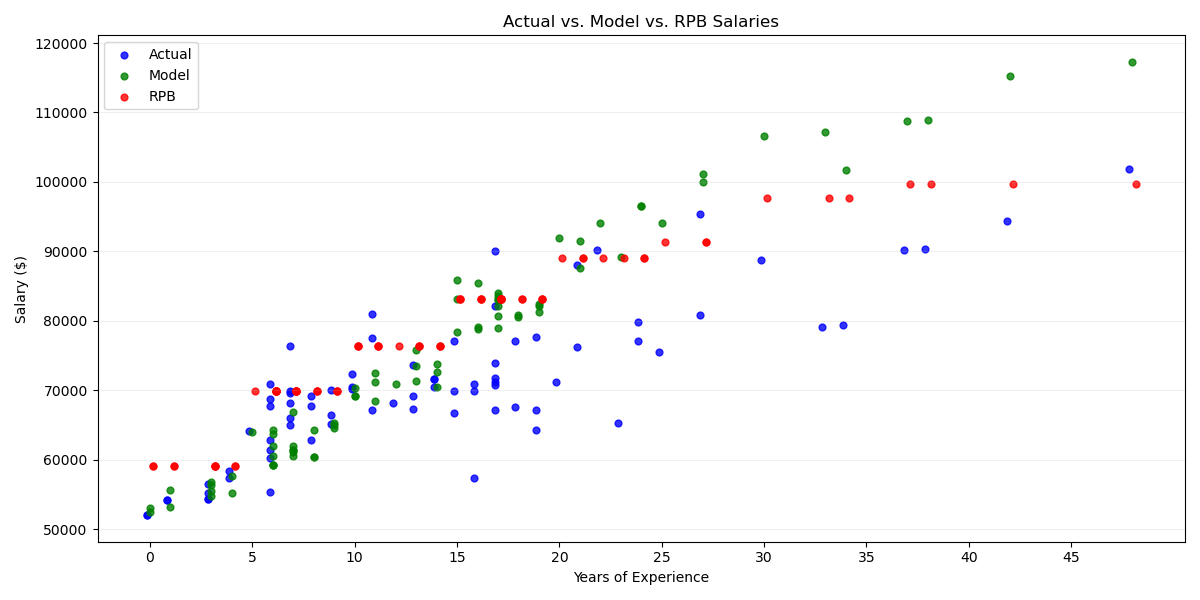

In [10]:
# --- Compare Actual vs Model vs RPB + total uplift-to-model cost ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns (adjust if your headers differ)
col_actual = "25-26 Salary"
col_model  = "Perfect World Salary"   # from your model cell
col_rpb    = "RPB Salary"
col_years  = "Years of Exp"
col_name   = "Employee"               # optional, only used for labeling if needed

# Filter to rows with all three salary values present
plot_df = (
    staff[[col_years, col_actual, col_model, col_rpb] + ([col_name] if col_name in staff.columns else [])]
    .copy()
    .dropna(subset=[col_years, col_actual, col_model, col_rpb])
)

# Uplift cost: bring anyone below model up to model (others unchanged)
deltas = np.maximum(plot_df[col_model].to_numpy() - plot_df[col_actual].to_numpy(), 0)
total_uplift_cost = float(np.nansum(deltas))
num_below_model = int(np.sum(deltas > 0))

# --- Gap vs. RPB target (in dollars) ---
df_comp = staff[[col_actual, col_model, col_rpb]].dropna()

baseline = np.maximum(df_comp[col_actual].to_numpy(),
                      df_comp[col_model].to_numpy())
target   = df_comp[col_rpb].to_numpy()

gap = float(np.nansum(target - baseline))
print(f"People below model: {num_below_model}")
print(f"Total cost to bring up to model: ${total_uplift_cost:,.0f}")
print(f"Total gap vs. RPB target ({target_percentile:,.0f}): ${gap:,.0f}")

# Plot: scatter by years; offset each series slightly to reduce overlap
x = plot_df[col_years].to_numpy()
eps = 0.15  # horizontal offset so points don't sit exactly on top of each other

plt.figure(figsize=(12, 6))
plt.scatter(x - eps, plot_df[col_actual], s=24, alpha=0.8, color="blue",  label="Actual")
plt.scatter(x,       plot_df[col_model],  s=24, alpha=0.8, color="green", label="Model")
plt.scatter(x + eps, plot_df[col_rpb],    s=24, alpha=0.8, color="red",   label="RPB")

plt.xlabel("Years of Experience")
plt.ylabel("Salary ($)")
plt.title("Actual vs. Model vs. RPB Salaries")
plt.grid(axis="y", alpha=0.2)

# x ticks every 5 years up to max observed or 40
max_years = max(40, int(np.nanmax(x)))
plt.xticks(np.arange(0, max_years + 1, 5))

# y-limits with some headroom
all_y = np.concatenate([plot_df[col_actual].to_numpy(),
                        plot_df[col_model].to_numpy(),
                        plot_df[col_rpb].to_numpy()])
ymin = np.nanmin(all_y)
ymax = np.nanmax(all_y)
pad  = 0.06 * (ymax - ymin if ymax > ymin else ymax)
plt.ylim(ymin - pad, ymax + pad)

plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [30]:
# --- Nonlinear salary model (exp half-lives + degree bumps that compound with experience) ---

import numpy as np
import pandas as pd

# ==== CONFIG (tune these) ====
base_salary             = 53500.0

# Experience contribution: cumulative effect with diminishing marginal return
exp_base_per_year       = 1950.0      # "first-year" marginal (before decay)
exp_half_life_years     = 15.0       # marginal halves after this many years

# Seniority-at-school contribution
sen_base_per_year       = 400.0
sen_half_life_years     = exp_half_life_years

# Degrees: flat bumps that compound by experience at a constant rate
deg_ma_base             = 1500.0     # MA flat bump at 0 years
deg_phd_base            = 2500.0     # PhD flat bump at 0 years
deg_growth_rate         = 0.03       # 2% per year compounding with *experience* (not seniority)
stack_degrees           = False      # if True, BA->MA plus MA->PhD; else use highest only

# Optional linear components (set to 0 to ignore)
w_skill                 = 0.0
w_prep                  = 2500.0
w_knowledge             = 1500.0
level_adders            = {"LS": 0.0, "MS": 0.0, "HS": 0.0}  # per-level adders

# Scale the whole curve (useful when "aiming" to an overall percentile)
aim_multiplier          = 1.0
# =============================

# --- Utilities ---
def _coerce_num(s):
    return pd.to_numeric(s, errors="coerce").fillna(0.0)

def exp_cumulative(years, base_per_year, half_life):
    """
    Continuous-time cumulative contribution with exponentially decaying marginal:
      marginal(t) = base_per_year * exp(-k t),  k = ln(2)/half_life
      cumulative(y) = ∫_0^y marginal(t) dt = base_per_year * (1 - exp(-k y)) / k
    """
    years = np.maximum(0.0, np.asarray(years, dtype=float))
    if half_life <= 0 or base_per_year == 0:
        return np.zeros_like(years, dtype=float)
    k = np.log(2.0) / float(half_life)
    return base_per_year * (1.0 - np.exp(-k * years)) / k

def degree_bump(edu_series, years_exp, deg_growth_rate, deg_ma_base, deg_phd_base, stack=False):
    """
    Degree bump that compounds with experience:
      bump_MA(y)  = deg_ma_base  * (1 + r)^y
      bump_PhD(y) = deg_phd_base * (1 + r)^y
    If stack=False, use only the highest attained bump. If stack=True, sum MA+PhD where applicable.
    """
    edu = edu_series.astype(str).str.upper().str.strip().fillna("")
    y   = np.maximum(0.0, np.asarray(years_exp, dtype=float))
    growth = np.power(1.0 + float(deg_growth_rate), y)

    ma_bump  = deg_ma_base  * growth
    phd_bump = deg_phd_base * growth

    # Heuristics to detect degrees; customize if your labels differ
    has_phd = edu.str.contains("PHD") | edu.str.contains("PH.D")
    has_ma  = edu.str.contains("MA") | edu.str.contains("M.A") | edu.str.contains("MS") | edu.str.contains("M.S")

    if stack:
        return (has_ma.astype(float) * ma_bump) + (has_phd.astype(float) * phd_bump)
    else:
        # Highest only: PhD overrides MA
        return np.where(has_phd, phd_bump, np.where(has_ma, ma_bump, 0.0))

# --- Build inputs from `staff` ---
sf = staff.copy()

# Ensure numeric
sf["Years of Exp"]   = _coerce_num(sf.get("Years of Exp", 0))
sf["Seniority"]      = _coerce_num(sf.get("Seniority", 0))
sf["Skill Rating"]   = _coerce_num(sf.get("Skill Rating", 0))
sf["Prep Rating"]    = _coerce_num(sf.get("Prep Rating", 0))
sf["Knowledge Rating"]= _coerce_num(sf.get("Knowledge Rating", 0))

# Experience & seniority contributions
exp_contrib = exp_cumulative(sf["Years of Exp"], exp_base_per_year, exp_half_life_years)
sen_contrib = exp_cumulative(sf["Seniority"],    sen_base_per_year, sen_half_life_years)

# Degree contributions (compound with experience)
deg_contrib = degree_bump(
    sf.get("Education Level", pd.Series(index=sf.index, dtype="object")),
    sf["Years of Exp"],
    deg_growth_rate=deg_growth_rate,
    deg_ma_base=deg_ma_base,
    deg_phd_base=deg_phd_base,
    stack=stack_degrees
)

# Optional linear adds
lvl = sf.get("Level", pd.Series(index=sf.index, dtype="object")).astype(str).str.upper().str.strip()
lvl_add = (
    np.where(lvl.eq("LS"), level_adders.get("LS", 0.0), 0.0) +
    np.where(lvl.eq("MS"), level_adders.get("MS", 0.0), 0.0) +
    np.where(lvl.eq("HS"), level_adders.get("HS", 0.0), 0.0)
)

linear_adds = (
    w_skill      * sf["Skill Rating"].to_numpy() +
    w_prep       * sf["Prep Rating"].to_numpy() +
    w_knowledge  * sf["Knowledge Rating"].to_numpy() +
    lvl_add
)

# Final nonlinear model
model_nl = aim_multiplier * (
    base_salary +
    exp_contrib +
    sen_contrib +
    deg_contrib +
    linear_adds
)

staff["Model NL Salary"] = model_nl

# Quick preview
cols = ["Employee", "Years of Exp", "Seniority", "Education Level", "Level",
        "Model NL Salary"]
print(staff[ [c for c in cols if c in staff.columns] ].head(10).to_string(index=False))

             Employee  Years of Exp  Seniority Education Level Level  Model NL Salary
       Joella, Katie            0.0          0              BA    HS     53950.000000
      Elston, Caron L           0.0          2             NaN    LS     54714.145168
     Dimond, Olivia D           1.0          0              BA    MS     55855.631477
       Pugh, Hannah E           1.0          0              BA    HS     58355.631477
Baumgartner, Rachel C           3.0          1              MA    MS     61442.604031
            Weintraub           3.0          3             NaN    LS     60533.151128
   Herndon, Natalie R           3.0          0              BA    MS     59712.614766
     Rosiere, Diana M           3.0          1              MA    MS     61892.604031
      Porter, Laine M           4.0          0              BA    LS     61071.563322
       Wang, Zhuoqun            4.0          1              MA Cross     63750.725302


In [31]:
# --- Simple Linear Salary Model (base + slope*years + static MA/PhD add) ---

import numpy as np
import pandas as pd

# ===== CONFIG: tune as needed =====
lin_base_salary   = 58000.0   # base for everyone
lin_slope_per_yr  = 1200.0    # dollars per year of experience
lin_add_ma        = 2000.0    # static add for Master's
lin_add_phd       = 4000.0    # static add for PhD (overrides MA if highest_only=True)
highest_only      = True      # if True, use only the highest degree bump (PhD > MA). If False, MA+PhD will stack.
aim_multiplier_lin = 1.0      # optional global scale (e.g., to align to a percentile)
# ==================================

# Ensure required columns exist and are numeric
sf = staff.copy()
sf["Years of Exp"] = pd.to_numeric(sf.get("Years of Exp", 0), errors="coerce").fillna(0.0)

# Normalize Education Level text
edu = sf.get("Education Level", pd.Series(index=sf.index, dtype="object")).astype(str).str.upper().str.strip()

# Degree detection (tweak the patterns if your labels differ)
has_phd = edu.str.contains(r"\bPH\.?D\b") | edu.str.contains("PHD")
has_ma  = edu.str.contains(r"\bM\.?A\b") | edu.str.contains("MA") | edu.str.contains(r"\bM\.?S\b") | edu.str.contains("MS")

# Degree bump
if highest_only:
    deg_add = np.where(has_phd, lin_add_phd,
               np.where(has_ma,  lin_add_ma, 0.0))
else:
    # Stack MA + PhD if both present (rare)
    deg_add = has_ma.astype(float) * lin_add_ma + has_phd.astype(float) * lin_add_phd

# Linear model
model_linear = aim_multiplier_lin * (lin_base_salary + lin_slope_per_yr * sf["Years of Exp"].to_numpy() + deg_add)

# Write back to staff
staff["Simple Linear Salary"] = model_linear

# Quick preview
cols = ["Employee", "Years of Exp", "Education Level", "Simple Linear Salary"]
print(staff[[c for c in cols if c in staff.columns]].head(10).to_string(index=False))

             Employee  Years of Exp Education Level  Simple Linear Salary
       Joella, Katie            0.0              BA               58000.0
      Elston, Caron L           0.0             NaN               58000.0
     Dimond, Olivia D           1.0              BA               59200.0
       Pugh, Hannah E           1.0              BA               59200.0
Baumgartner, Rachel C           3.0              MA               63600.0
            Weintraub           3.0             NaN               61600.0
   Herndon, Natalie R           3.0              BA               61600.0
     Rosiere, Diana M           3.0              MA               63600.0
      Porter, Laine M           4.0              BA               62800.0
       Wang, Zhuoqun            4.0              MA               64800.0


=== Gap & Uplift Stats vs 50 ===
EGB_LM:
  People below: 48
  Total uplift to model: $503,852 (avg $6,460/person)
  Gap vs RPB from baseline max(Real,EGB_LM): $40,095 (avg $514/person)
EGB_NLM:
  People below: 68
  Total uplift to model: $499,539 (avg $6,404/person)
  Gap vs RPB from baseline max(Real,EGB_NLM): $44,408 (avg $569/person)
SLM:
  People below: 64
  Total uplift to model: $501,692 (avg $6,432/person)
  Gap vs RPB from baseline max(Real,SLM): $42,255 (avg $542/person)



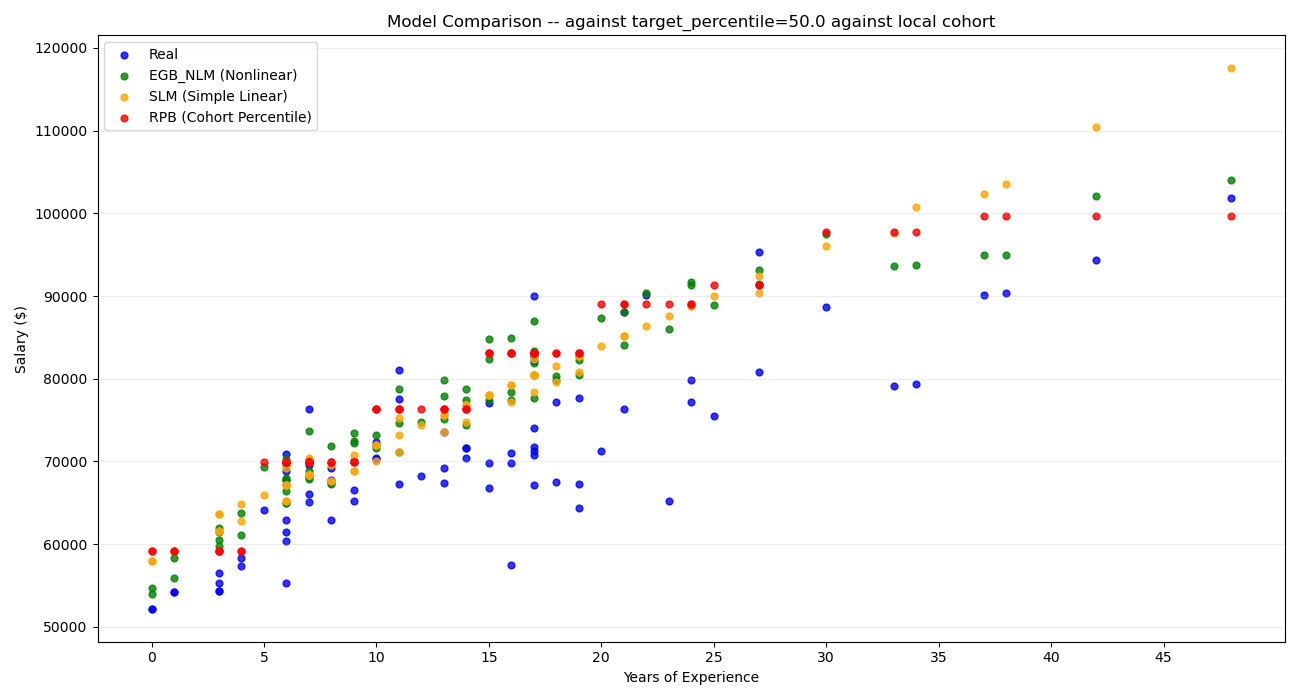

In [34]:
# --- Master comparison plot + metrics (Real vs. 3 models vs. RPB) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Column aliases
col_real = "25-26 Salary"
col_egb_lm = "Perfect World Salary"   # earlier "linear" model
col_egb_nlm = "Model NL Salary"       # nonlinear model
col_slm = "Simple Linear Salary"       # simple linear model
col_rpb = "RPB Salary"
col_years = "Years of Exp"
col_name = "Employee"                 # optional

# Ensure all required columns are present
cols_needed = [col_real, col_egb_lm, col_egb_nlm, col_slm, col_rpb, col_years]
plot_df = staff[cols_needed + ([col_name] if col_name in staff.columns else [])].dropna()

# Extract arrays
a   = plot_df[col_real].to_numpy()
lm  = plot_df[col_egb_lm].to_numpy()
nlm = plot_df[col_egb_nlm].to_numpy()
slm = plot_df[col_slm].to_numpy()
rpb = plot_df[col_rpb].to_numpy()

# -----------------------------
# Metrics
# -----------------------------

def uplift_and_gap(model_vals, label):
    """Return uplift stats (only raise those below model) and gap vs RPB baseline."""
    uplift = np.maximum(model_vals - a, 0)
    total_uplift = float(np.nansum(uplift))
    num_below = int(np.sum(uplift > 0))
    avg_uplift = total_uplift / len(plot_df)

    baseline = np.maximum(a, model_vals)
    gap = float(np.nansum(rpb - baseline))
    avg_gap = gap / len(plot_df)

    return {
        "label": label,
        "num_below": num_below,
        "total_uplift": total_uplift,
        "avg_uplift": avg_uplift,
        "gap_vs_rpb": gap,
        "avg_gap_vs_rpb": avg_gap
    }

stats = []
stats.append(uplift_and_gap(lm,  "EGB_LM"))
stats.append(uplift_and_gap(nlm, "EGB_NLM"))
stats.append(uplift_and_gap(slm, "SLM"))

# Try to display percentile if available
try:
    tp_display = f"{int(round(float(target_percentile)))}"
except Exception:
    tp_display = "RPB target"

print(f"=== Gap & Uplift Stats vs {tp_display} ===")
for s in stats:
    print(f"{s['label']}:")
    print(f"  People below: {s['num_below']}")
    print(f"  Total uplift to model: ${s['total_uplift']:,.0f} (avg ${s['avg_uplift']:,.0f}/person)")
    print(f"  Gap vs RPB from baseline max(Real,{s['label']}): ${s['gap_vs_rpb']:,.0f} (avg ${s['avg_gap_vs_rpb']:,.0f}/person)")
print("")

# -----------------------------
# Plot
# -----------------------------
x = plot_df[col_years].to_numpy()
eps = 0.  # horizontal offset for clarity

plt.figure(figsize=(13, 7))
plt.scatter(x - 2*eps, a,   s=24, alpha=0.8, color="blue",   label="Real")
# plt.scatter(x - eps,   lm,  s=24, alpha=0.8, color="purple", label="EGB_LM (Perfect World)")
plt.scatter(x,         nlm, s=24, alpha=0.8, color="green",  label="EGB_NLM (Nonlinear)")
plt.scatter(x + eps,   slm, s=24, alpha=0.8, color="orange", label="SLM (Simple Linear)")
plt.scatter(x + 2*eps, rpb, s=24, alpha=0.8, color="red",    label="RPB (Cohort Percentile)")

plt.xlabel("Years of Experience")
plt.ylabel("Salary ($)")
plt.title(f"Model Comparison -- against target_percentile={target_percentile} against local cohort")
plt.grid(axis="y", alpha=0.2)

# x ticks every 5 years up to max observed or 40
max_years = max(40, int(np.nanmax(x)))
plt.xticks(np.arange(0, max_years + 1, 5))

# y-limits with headroom
all_y = np.concatenate([a, lm, nlm, slm, rpb])
ymin = np.nanmin(all_y)
ymax = np.nanmax(all_y)
pad  = 0.06 * (ymax - ymin if ymax > ymin else max(ymax, 1))
plt.ylim(ymin - pad, ymax + pad)

plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [15]:
# --- Calculate theoretical bump to reach nonlinear model, show top bumps ---
plt.close('all')
col_actual = "25-26 Salary"
col_model  = "Model NL Salary"
col_name   = "Employee"   # adjust if your column differs

# Calculate bump: only positive differences (no pay cuts)
staff["NL Bump"] = np.maximum(staff[col_model] - staff[col_actual], 0)

num_to_show = 25
# Sort staff by largest bump
top_bumps = (
    staff[[col_name, "Years of Exp", col_actual, col_model, "NL Bump"]]
    .dropna(subset=["NL Bump"])
    .sort_values("NL Bump", ascending=False)
    .head(num_to_show)
)

# Display top 25 bumps
print(f"Top {num_to_show} theoretical bumps to reach nonlinear model:")
display(top_bumps.style.format({
    col_actual: "${:,.0f}",
    col_model: "${:,.0f}",
    "NL Bump": "${:,.0f}"
}))

Top 25 theoretical bumps to reach nonlinear model:


,Employee,Years of Exp,25-26 Salary,Model NL Salary,NL Bump
62,"Hon, Rebecca M",23.000000,"$65,259","$85,367","$20,108"
46,"Turnbull, Jennie",16.000000,"$57,463","$77,267","$19,804"
33,"Fonseca, Ana J",15.000000,"$66,744","$84,637","$17,893"
47,"Lantagne, Michael K",19.000000,"$64,318","$79,999","$15,681"
54,"Summers, Amber",20.000000,"$71,209","$86,874","$15,665"
49,"Herman, Bonnie J",19.000000,"$67,220","$81,834","$14,614"
53,"Boss, Christine M",16.000000,"$70,967","$84,708","$13,741"
65,"May, Julie",24.000000,"$77,182","$90,655","$13,473"
11,"Von Tscharner, Emma M",6.000000,"$55,328","$68,769","$13,441"
72,"Rodgers, Andy",33.000000,"$79,173","$92,608","$13,435"


In [19]:
# --- Band-wise median table: Real, EGB_LM, EGB_NLM, SLM, RPB ---

import numpy as np
import pandas as pd
import re

# Columns (change if your headers differ)
col_real   = "25-26 Salary"
col_lm     = "Perfect World Salary"    # EGB_LM
col_nlm    = "Model NL Salary"         # EGB_NLM
col_slm    = "Simple Linear Salary"     # SLM
col_rpb    = "RPB Salary"              # RPB
col_years  = "Years of Exp"

# ---- Helpers to align with your earlier contiguous bands (0-5, 5-10, …, 35+)
def band_range_contiguous(label: str):
    m = re.match(r"^\s*(\d+)\s*(?:-\s*(\d+)|\+)\s*yrs\s*$", str(label))
    if not m:
        raise ValueError(f"Unrecognized band label: {label}")
    a = int(m.group(1))
    start = a if a == 0 else a - 1
    end = start + 5
    return start, end

def build_band_bins(long_df: pd.DataFrame):
    bands = sorted(
        long_df["experience_band"].dropna().unique(),
        key=lambda b: band_range_contiguous(b)[0]
    )
    out = []
    for b in bands:
        s, e = band_range_contiguous(b)
        if "+" in str(b):
            out.append((s, np.inf, b))
        else:
            out.append((s, e, b))
    return out, bands

def assign_band_from_years(years: float, bins):
    if pd.isna(years):
        return np.nan
    y = float(years)
    for s, e, label in bins:
        if e == np.inf:
            if y >= s:
                return label
        else:
            if (y >= s) and (y < e):
                return label
    return np.nan

# Build bins from your benchmark table `long`
bins, band_order = build_band_bins(long)

# Prepare a working frame
cols_needed = [col_years, col_real, col_lm, col_nlm, col_slm, col_rpb]
missing = [c for c in cols_needed if c not in staff.columns]
if missing:
    raise ValueError(f"Missing required columns in staff: {missing}")

bw = staff[cols_needed].copy()
bw["Band"] = bw[col_years].apply(lambda y: assign_band_from_years(y, bins))

# Keep rows that mapped to a known band
bw = bw[bw["Band"].isin(band_order)].copy()

# Compute headcount per band (optional, useful context)
headcount = bw.groupby("Band", as_index=True).size().reindex(band_order, fill_value=0)
headcount.name = "Headcount"

# Median by band for each series
medians = (
    bw.groupby("Band", as_index=True)[[col_real, col_lm, col_nlm, col_slm, col_rpb]]
      .median()
      .reindex(band_order)
      .T  # rows = models, cols = bands
)

# Rename rows to requested abbreviations
row_map = {
    col_real: "Real",
    col_lm:   "EGB_LM",
    col_nlm:  "EGB_NLM",
    col_slm:  "SLM",
    col_rpb:  "RPB",
}
medians.index = [row_map.get(r, r) for r in medians.index]

# Append headcount as the last row (not currency)
table = medians.copy()
table.loc["Headcount"] = headcount.to_numpy()

# Optional: currency formatting for the salary rows only
def fmt_money(v):
    try:
        return f"${v:,.0f}"
    except Exception:
        return v

salary_rows = ["Real", "EGB_LM", "EGB_NLM", "SLM", "RPB"]
styled = (
    table.style
         .format(fmt_money, subset=pd.IndexSlice[salary_rows, :])
         .format("{:,.0f}", subset=pd.IndexSlice[["Headcount"], :])
)

# Display
display(styled)

# If you also want a plain DataFrame for export, keep `table`
# e.g., table.to_csv("band_wise_medians.csv")

Band,0-5 yrs,6-10 yrs,11-15 yrs,16-20 yrs,21-25 yrs,26-30 yrs,31-35 yrs,36+ yrs
Real,"$54,302","$67,138","$70,473","$70,864","$77,182","$80,874","$79,378","$92,356"
EGB_LM,"$55,350","$61,700","$71,150","$82,125","$91,950","$100,050","$106,650","$112,050"
EGB_NLM,"$61,203","$69,152","$74,860","$81,748","$87,608","$90,656","$92,642","$97,300"
SLM,"$61,600","$68,400","$74,400","$80,400","$86,400","$90,400","$97,600","$107,000"
RPB,"$59,163","$69,900","$76,400","$83,150","$89,000","$91,380","$97,756","$99,730"
Headcount,10,20,13,18,7,3,3,4
